In [62]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import matplotlib.colors
import sastool

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [110]:
%%cython --annotate
# cython: cdivision=True, wraparound=False, boundscheck=False, language_level=3, embedsignature=True
cimport numpy as np
ctypedef np.uint8_t uint8_t
ctypedef np.int32_t int32_t
ctypedef np.int8_t int8_t
ctypedef np.int16_t int16_t

def cbfdecompress(const uint8_t [:] inarray, int32_t[:] outarray):
    """Citation from http://www.bernstein-plus-sons.com/software/CBF/doc/CBFLIB.html#3.3

        The "byte_offset" compression algorithm is the following:

            1. Start with a base pixel value of 0.
            2. Compute the difference delta between the next pixel value and the base pixel value.
            3. If -127 ≤ delta ≤ 127, output delta as one byte, make the current pixel value the base pixel value and
               return to step 2.
            4. Otherwise output -128 (80 hex).
            5. We still have to output delta. If -32767 ≤ delta ≤ 32767, output delta as a little_endian 16-bit
               quantity, make the current pixel value the base pixel value and return to step 2.
            6. Otherwise output -32768 (8000 hex, little_endian, i.e. 00 then 80)
            7. We still have to output delta. If -2147483647 ≤ delta ≤ 2147483647, output delta as a little_endian 32
               bit quantity, make the current pixel value the base pixel value and return to step 2.
            8. Otherwise output -2147483648 (80000000 hex, little_endian, i.e. 00, then 00, then 00, then 80) and then
               output the pixel value as a little-endian 64 bit quantity, make the current pixel value the base pixel
               value and return to step 2.

        The "byte_offset" decompression algorithm is the following:

            1. Start with a base pixel value of 0.
            2. Read the next byte as delta
            3. If -127 ≤ delta ≤ 127, add delta to the base pixel value, make that the new base pixel value, place it on
               the output array and return to step 2.
            4. If delta is 80 hex, read the next two bytes as a little_endian 16-bit number and make that delta.
            5. If -32767 ≤ delta ≤ 32767, add delta to the base pixel value, make that the new base pixel value, place
               it on the output array and return to step 2.
            6. If delta is 8000 hex, read the next 4 bytes as a little_endian 32-bit number and make that delta
            7. If -2147483647 ≤ delta ≤ 2147483647, add delta to the base pixel value, make that the new base pixel
               value, place it on the output array and return to step 2.
            8. If delta is 80000000 hex, read the next 8 bytes as a little_endian 64-bit number and make that delta,
               add delta to the base pixel value, make that the new base pixel value, place it on the output array and
               return to step 2.

    ( end of cite).

    I.e. the special cases:

     (4)        (6)              (8)
    <0x80>|<0x00><0x80>|<0x00><0x00><0x00><0x80>
    """
    cdef:
        Py_ssize_t nbytes = inarray.size, iin = 0, iout = 0, nout = outarray.size
        int32_t lastvalue = 0

    while iin < nbytes:
        if inarray[iin] != 0x80:
            # difference stored on one byte
            outarray[iout] = lastvalue + <int8_t>(inarray[iin])
            iin += 1
        elif not ((inarray[iin+1] == 0x00) and (inarray[iin+2] == 0x80)):
            # difference stored on two bytes
            outarray[iout] = lastvalue + <int16_t>(inarray[iin+1] + 0x100*inarray[iin+2])
            iin += 3
        elif not ((inarray[iin+3] == 0x00)
                  and (inarray[iin+4] == 0x00) and (inarray[iin+5] == 0x00) and (inarray[iin+6] == 0x80)):
            # difference stored on four bytes
            outarray[iout] = lastvalue + <int32_t>(
                inarray[iin+3] + 0x100*inarray[iin+4] + 0x10000*inarray[iin+5] + 0x1000000*inarray[iin+6])
            iin += 7
        else:
            raise ValueError('Cannot load 64-bit data')
        lastvalue=outarray[iout]
        iout +=1
        if iout >= nout:
            break
    if iout != nout:
        raise ValueError('Binary data does not have enough points.')
    return outarray

def trunc8(int32_t intvalue):
    return <int8_t>intvalue

def trunc16(int32_t intvalue):
    return <int16_t>intvalue

-2 1053
-2.0 1053.0


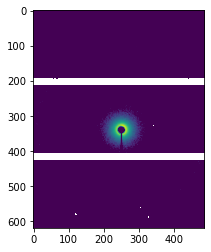

In [105]:
import numpy as np


def readcbf(filename: str):
    header = {}
    with open(filename, 'rb') as f:
        dim1 = None
        dim2 = None
        while (line := f.readline().strip()) != b'--CIF-BINARY-FORMAT-SECTION--':
            pass
        while line := f.readline().strip():
            if line.startswith(b'conversions=') and (line != b"conversions=\"x-CBF_BYTE_OFFSET\""):
                raise RuntimeError('Unsupported CBF compression')
            if line.startswith(b'Content-Transfer-Encoding:') and (line != b"Content-Transfer-Encoding: BINARY"):
                raise RuntimeError('Unsupported content transfer encoding')
            if line.startswith(b'X-Binary-Element-Type:') and (line != b"X-Binary-Element-Type: \"signed 32-bit integer\""):
                raise RuntimeError('Unsupported binary element type')
            if line.startswith(b'X-Binary-Element-Byte-Order:') and (line != b"X-Binary-Element-Byte-Order: LITTLE_ENDIAN"):
                raise RuntimeError('Unsupported binary element byte order')
            if line.startswith(b'X-Binary-Size-Fastest-Dimension:'):
                dim1 = int(line.split()[-1])
            elif line.startswith(b'X-Binary-Size-Second-Dimension:'):
                dim2 = int(line.split()[-1])
    if dim1 is None or dim2 is None:
        raise RuntimeError('Image dimensions not found in file.')
    with open(filename, 'rb') as f:
        data = f.read()
        data = np.frombuffer(data[data.find(b'\x0c\x1a\x04\xd5') + 4:], np.uint8)
        output = np.empty(dim1* dim2, order='C', dtype=np.int32)
        data = cbfdecompress(data, output)
    return output.reshape(dim2, dim1)
filename = '../test/images_local/tst/tst_00300.cbf'
data=readcbf(filename)
dataorig = sastool.io.twodim.readcbf(filename)[0]
plt.imshow(data, norm=matplotlib.colors.LogNorm())
print(data.min(), data.max())
print(dataorig.min(), dataorig.max())

0.0 0.0


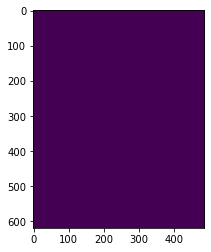

In [106]:
diff=(data-dataorig)
plt.imshow(diff)
print(diff.min(), diff.max())

In [107]:
trunc8(128)

-128

In [108]:
%timeit readcbf(filename)
%timeit sastool.io.twodim.readcbf(filename)

383 µs ± 7.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.89 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
4.89/0.383

12.767624020887727